In [2]:
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from statistics import mean
import impaintingLib as imp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_img(x):
    img_grid = make_grid(x[:16])
    plt.figure(figsize=(20,15))
    plt.imshow(img_grid.cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.show()

### Méthode pour ségmenter l'input

In [3]:
import impaintingLib as imp
classif = imp.loss.getTrainedModel()

def simplifyChannels(x):
    x = np.where(x == 3, 0, x) 
    x = np.where(x == 4, 3, x) 
    x = np.where(x == 5, 3, x) 
    x = np.where(x == 6, 4, x) 
    x = np.where(x == 7, 4, x) 
    x = np.where(x == 8, 5, x) 
    x = np.where(x == 9, 5, x) 
    x = np.where(x == 10 , 6, x) 
    x = np.where(x == 11, 7, x) 
    x = np.where(x == 12, 7, x)  
    x = np.where(x > 12, 0, x) 
    return (x / 9) + 0.1

def npToTensor(x):
    c,w,h = x.shape
    x = torch.from_numpy(x).to(device)
    x = torch.reshape(x, (c,1,w,h))
    return x.float()

def get_segmentation(x, segmenter=classif, scale_factor=4, simplify=True):
    n,c,w,h = x.shape
    with torch.no_grad():
        if scale_factor > 0 :
            x = torch.nn.functional.interpolate(x, scale_factor=scale_factor)
        x = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(x)
        y = classif(x)
        if scale_factor > 0 :
            y = torch.nn.functional.avg_pool2d(y, scale_factor)
    if simplify: 
        y = imp.loss.generate_label_plain(y,w)
        y = simplifyChannels(y)
        y = npToTensor(y)
        return y
    else: 
        return y

### Comparaison segmentation : 64x64 maxpool ou enhance

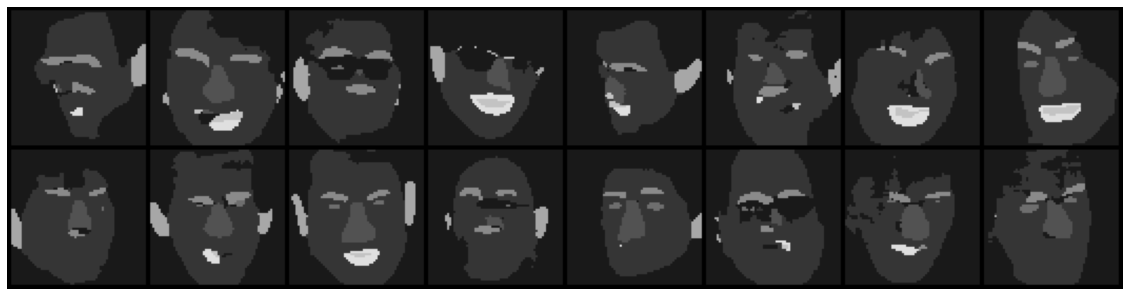

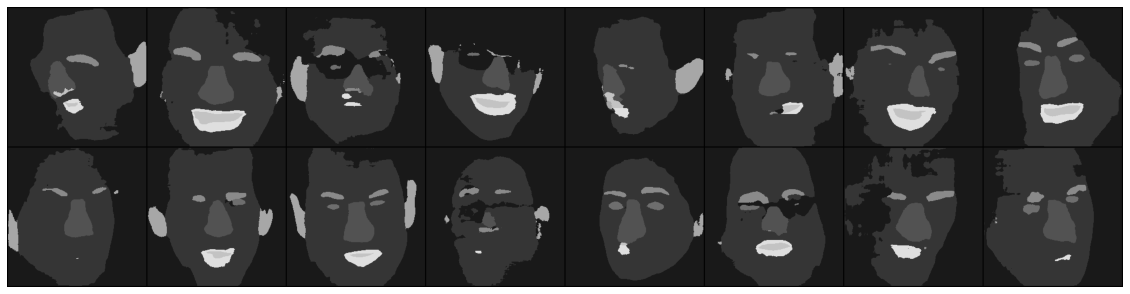

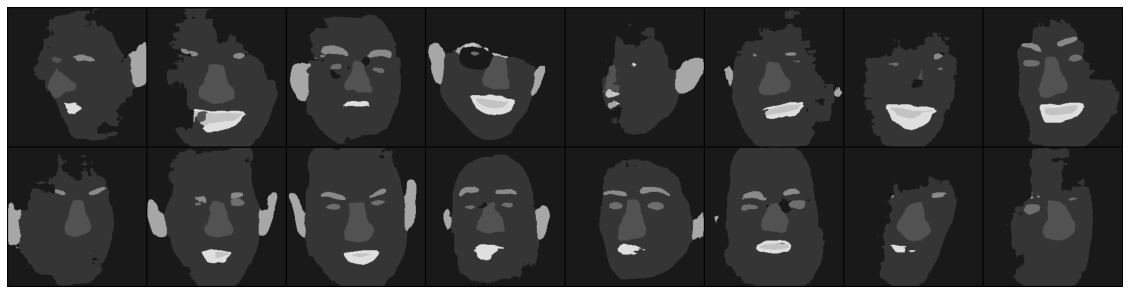

In [4]:
process = transforms.ToTensor()
dataset = ImageFolder("./data/lfw", process)
data = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True)
img,_ = next(iter(data))

resize = (120, 120)
crop   = (64, 64)
x = transforms.Resize(resize)(img)
x = transforms.CenterCrop(crop)(x)
x = x.to(device)
n,c,w,h = x.shape

# Maxpool
segmented = get_segmentation(x, simplify=True, scale_factor=4)
plot_img(segmented)

# Enhance
with torch.no_grad():
    model_path = 'modelSave/RRDB_ESRGAN_x4.pth'
    enhancer = imp.model.RRDBNet(3, 3, 64, 23, gc=32)
    enhancer.load_state_dict(torch.load(model_path), strict=True)
    enhancer.eval()
    enhancer = enhancer.to(device)
    x = enhancer(x)
    segmented = get_segmentation(x, simplify=True, scale_factor=1)
    plot_img(segmented)
    
# Haute résolution direct
resize = (120*4, 120*4)
crop   = (64*4, 64*4)
x = transforms.Resize(resize)(img)
x = transforms.CenterCrop(crop)(x)
x = x.to(device)
n,c,w,h = x.shape

# Maxpool
segmented = get_segmentation(x, simplify=True, scale_factor=0)
plot_img(segmented)

In [5]:
def train_inpainting_segmented(net, optimizer, loader, alter, scale_factor=4, epochs=5, min_cut=15,max_cut=45, simplify_seg=True, show_images=True):
    
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            segmented = get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
            x_prime = alter(x)
            x_input = torch.cat((x_prime, segmented),dim=1)
            outputs = net(x_input)
            
            loss = torch.nn.L1Loss()(outputs, x) 
            loss += imp.loss.perceptualVGG(outputs, x) 
            loss += imp.loss.totalVariation(outputs, x)
            
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}, epoch: {epoch}/{epochs}')
        if show_images:
            plot_img(x[:8])
            plot_img(x_prime[:8])
            if simplify_seg:
                plot_img(segmented[:8])
            else:
                classifDisplay = imp.loss.generate_label(segmented,w).to(device)
                plot_img(classifDisplay[:8])
            plot_img(torch.clip(outputs[:8], 0, 1))
            
def test_results_sample(net, testloader, alter, simplify_seg=True, min_cut=15,max_cut=45, scale_factor=4):
    with torch.no_grad():
        x, _ = next(iter(testloader))
        x = x.to(device)
        segmented = get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
        x_prime = alter(x)
        x_input = torch.cat((x_prime, segmented),dim=1)
        outputs = net(x_input)
        plot_img(x[:8])
        plot_img(x_prime[:8])
        if simplify_seg:
            plot_img(segmented[:8])
        else:
            segmented = transforms.Resize((256,256))(segmented)
            classifDisplay = imp.loss.generate_label(segmented,w).to(device)
            plot_img(classifDisplay[:8])
        plot_img(torch.clip(outputs[:8], 0, 1))

### Train avec noir et blanc

In [32]:
factorResize = 1
model = imp.model.UNet(4, netType="partial").to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
trainloader, testloader = imp.data.getFaces(shuffle=True,resize=factorResize)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask

In [ ]:
train_inpainting_segmented(model, optimizer, trainloader, alter, scale_factor=4, simplify_seg=True, epochs=7, min_cut=4, max_cut=60)
torch.save(model.state_dict(), "./modelSave/02_08/partial4channels_low")

### Test avec noir et blanc

In [33]:
def getTestData(file,factorResize=1):
    resize = (120*factorResize, 120*factorResize)
    crop   = (64*factorResize, 64*factorResize)
    process = transforms.Compose([
         transforms.Resize(resize), 
         transforms.CenterCrop(crop),
         transforms.ToTensor()
    ])
    return ImageFolder(file, process)

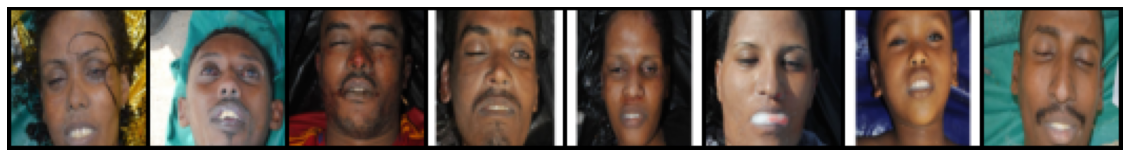

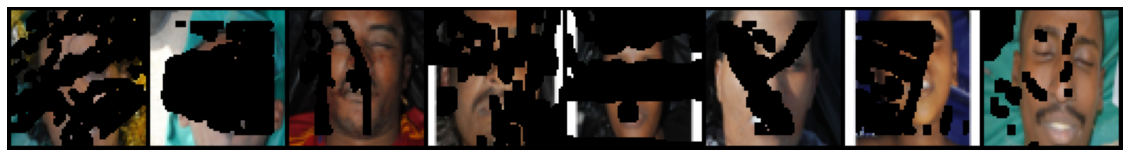

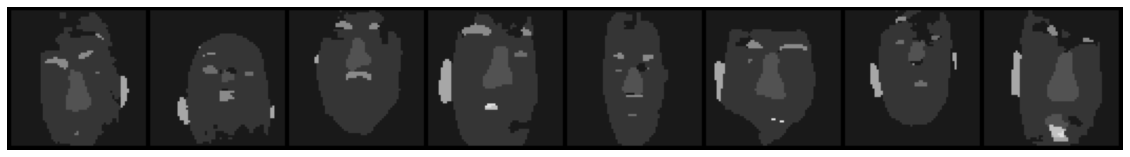

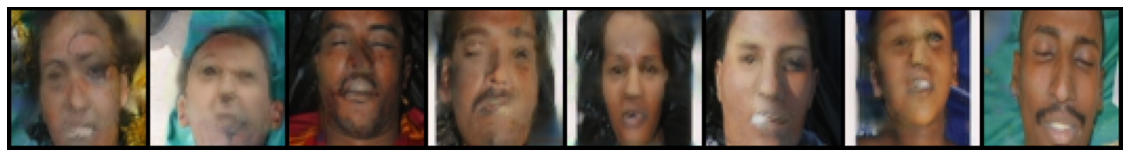

In [37]:
dataset = getTestData("./data/real")
testloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True)
model.load_state_dict(torch.load("./modelSave/02_08/partial4channels_low"))
model.eval()
test_results_sample(model, testloader, alter, simplify_seg=True,scale_factor=4)

### Train noir et blanc 128x128

In [6]:
factorResize = 2
model = imp.model.UNet(4, netType="partial").to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
trainloader, testloader = imp.data.getFaces(shuffle=True,resize=factorResize)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask

  0%|          | 0/373 [00:00<?, ?it/s]

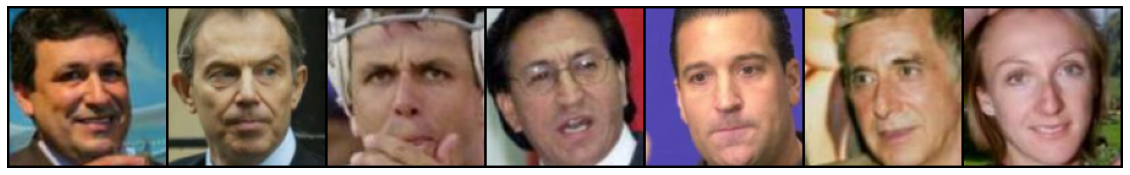

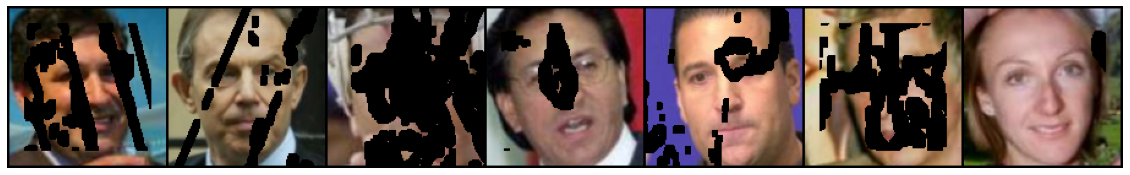

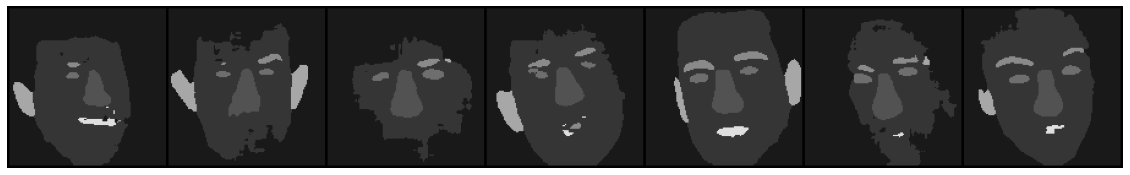

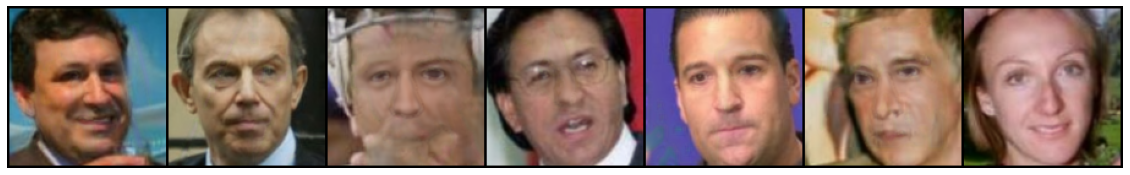

In [7]:
model.load_state_dict(torch.load("./modelSave/02_08/partial4channels_mid"))
model.eval
train_inpainting_segmented(model, optimizer, trainloader, alter, scale_factor=2, simplify_seg=True, epochs=1)
torch.save(model.state_dict(),"./modelSave/02_08/partial4channels_mid")